[Info] KLAAD detected as LoRA adapter. Included.

[Run] ORIGINAL


Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]
/home/zikang.ding/envs/bias/lib/python3.10/site-packages/transformers/utils/generic.py:1014: UserWarning: `output_attentions=True` is not supported with `attn_implementation` other than ['eager', 'eager_paged', 'flex_attention']. Please use `model.set_attn_implementation('eager')` to enable capturing attention outputs.
  warnings.warn(


  n_layers = 32
  baseline gap (X_HE)  = 2.4531
  baseline gap (X_SHE) = 0.0938


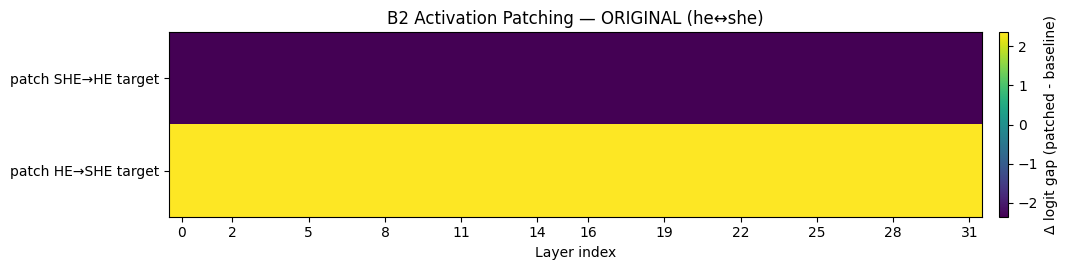

[Saved] ./B2_patching_figs/B2_patch_heatmap_ORIGINAL.png

[Run] CDA


Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


  n_layers = 32
  baseline gap (X_HE)  = -0.0625
  baseline gap (X_SHE) = -0.5625


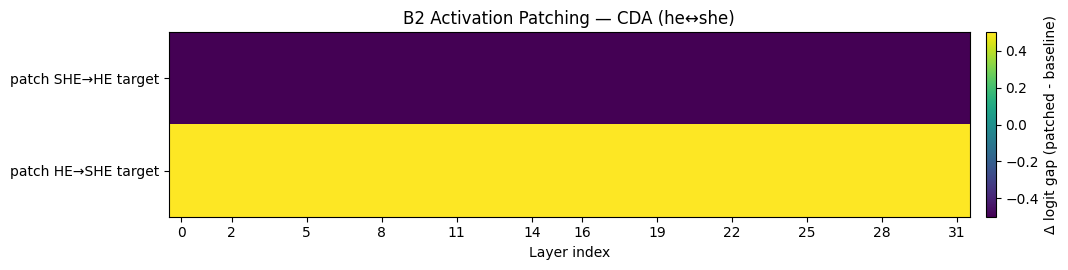

[Saved] ./B2_patching_figs/B2_patch_heatmap_CDA.png

[Run] UGID


Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


  n_layers = 32
  baseline gap (X_HE)  = -0.0625
  baseline gap (X_SHE) = -0.0312


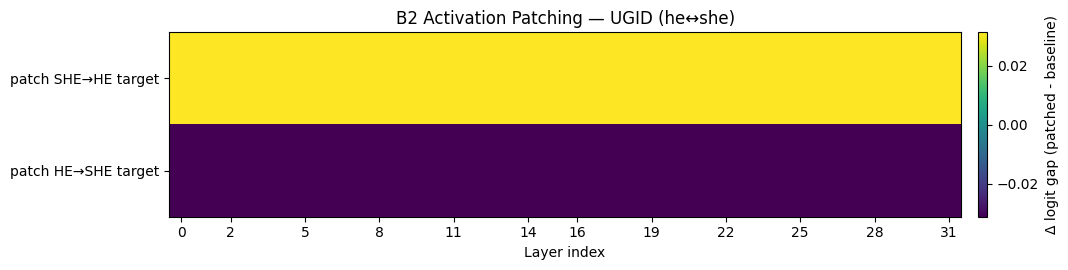

[Saved] ./B2_patching_figs/B2_patch_heatmap_UGID.png

[Run] KLAAD


Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


  n_layers = 32
  baseline gap (X_HE)  = 0.0625
  baseline gap (X_SHE) = 0.9375


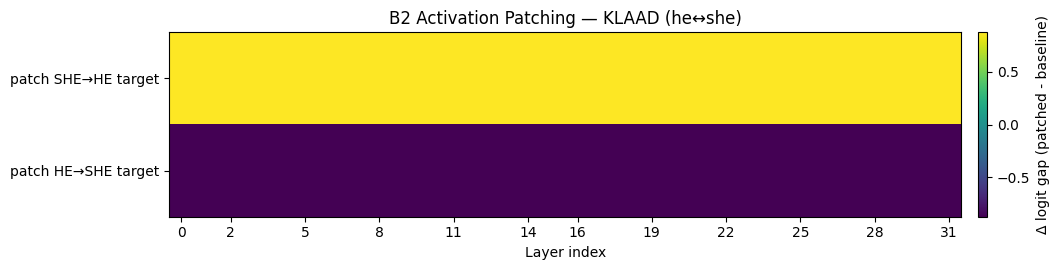

[Saved] ./B2_patching_figs/B2_patch_heatmap_KLAAD.png

Done. All figures saved to: ./B2_patching_figs


In [3]:
#!/usr/bin/env python3
# B2: Activation Patching / Causal Tracing (stable, architecture-agnostic)
# Patch residual stream at a chosen layer & position, measure effect on next-token pronoun gap.

import os
import gc
import warnings
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -------------------------
# 0) Housekeeping
# -------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ.setdefault("TRANSFORMERS_VERBOSITY", "error")
warnings.filterwarnings("ignore", message="IProgress not found")
warnings.filterwarnings("ignore", message="The tokenizer you are loading")
warnings.filterwarnings("ignore", message="torch_dtype is deprecated")
warnings.filterwarnings("ignore", message="The following generation flags are not valid")
warnings.filterwarnings("ignore", message="The current process just got forked")

# -------------------------
# 1) Paths
# -------------------------
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")  # optional

OUT_DIR = "./B2_patching_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# 2) Pair to patch (he <-> she)
#    (keeps same length & almost same tokens except pronoun)
# -------------------------
X_HE  = "The engineer said that he"
X_SHE = "The engineer said that she"

# Layers to test (None => all)
TARGET_LAYERS = None  # e.g., [0,1,2,5,10,15,20,25,31]

# -------------------------
# 3) Tokenizer
# -------------------------
def load_tokenizer(path):
    try:
        tok = AutoTokenizer.from_pretrained(path, use_fast=True, fix_mistral_regex=True)
    except TypeError:
        tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    tok.pad_token = tok.eos_token
    return tok

tokenizer = load_tokenizer(ORIG_DIR)

def _single_token_id_or_warn(tok_str: str) -> int:
    ids = tokenizer(tok_str, add_special_tokens=False).input_ids
    if len(ids) == 1:
        return ids[0]
    print(f"[WARN] token {tok_str!r} not single-token; using first subtoken (len={len(ids)}).")
    return ids[0]

HE_ID  = _single_token_id_or_warn(" he")
SHE_ID = _single_token_id_or_warn(" she")

# -------------------------
# 4) Model loaders
# -------------------------
def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

def load_original_full():
    # bfloat16 on GPU if possible; auto device_map
    try:
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            dtype=getattr(torch, "bfloat16", torch.float16),
            device_map="auto",
            output_hidden_states=False,
        )
    except Exception as e:
        print(f"[Info] device_map auto failed ({e}), fallback CPU fp32.")
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.float32,
            device_map={"": "cpu"},
            output_hidden_states=False,
        )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

# -------------------------
# 5) Robust layer finder (architecture-agnostic)
# -------------------------
def _unwrap_backbone(model):
    # unwrap PEFT (most common)
    if hasattr(model, "base_model") and hasattr(model.base_model, "model"):
        return model.base_model.model
    return model

def get_decoder_layers(model):
    """
    Return a ModuleList / list of decoder blocks across common HF architectures.
    """
    m = _unwrap_backbone(model)

    # fast path candidates
    candidates = [
        ("model", "layers"),          # LLaMA-like
        ("layers",),                  # Qwen2Model.layers
        ("transformer", "h"),         # GPT2/Falcon
        ("gpt_neox", "layers"),       # GPTNeoX/Pythia
        ("model", "decoder", "layers"),
        ("decoder", "layers"),
        ("decoder", "block"),         # T5
        ("model", "decoder", "block"),
    ]
    for path in candidates:
        obj = m
        ok = True
        for p in path:
            if not hasattr(obj, p):
                ok = False
                break
            obj = getattr(obj, p)
        if ok and isinstance(obj, (nn.ModuleList, list, tuple)) and len(obj) > 0 and isinstance(obj[0], nn.Module):
            return obj

    # fallback: scan for best ModuleList
    best = None
    best_score = -1

    def score_block(block: nn.Module) -> int:
        names = set(dict(block.named_modules()).keys())
        s = 0
        for key in ["self_attn", "attn", "attention", "mlp", "ffn", "feed_forward"]:
            if any(key in n for n in names):
                s += 1
        return s

    for _, mod in m.named_modules():
        if isinstance(mod, nn.ModuleList) and len(mod) > 0 and isinstance(mod[0], nn.Module):
            s = score_block(mod[0]) * 1000 + len(mod)
            if s > best_score:
                best_score = s
                best = mod

    if best is None:
        raise RuntimeError("Cannot find decoder layers. Please print(model) backbone structure.")
    return best

# -------------------------
# 6) Next-token logit gap (he - she) at last position
# -------------------------
@torch.no_grad()
def next_token_logit_gap(model, text: str) -> float:
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt").to(device)
    out = model(**inputs)
    logits = out.logits  # [B,S,V]
    last_logits = logits[0, -1, :].float()
    return float((last_logits[HE_ID] - last_logits[SHE_ID]).item())

# -------------------------
# 7) Capture per-layer residual stream at last position
#    We hook each decoder block and store its output hidden state at position pos.
# -------------------------
@torch.no_grad()
def capture_layer_outputs_at_pos(model, text: str):
    layers = get_decoder_layers(model)
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt").to(device)
    pos = inputs["input_ids"].shape[1] - 1

    captured = [None] * len(layers)
    hooks = []

    def make_hook(i):
        def hook_fn(module, inp, out):
            # out could be Tensor or tuple (hidden_states, ...)
            hs = out[0] if isinstance(out, (tuple, list)) else out  # [B,S,D]
            captured[i] = hs[0, pos, :].detach()
        return hook_fn

    for i, layer in enumerate(layers):
        hooks.append(layer.register_forward_hook(make_hook(i)))

    _ = model(**inputs)

    for h in hooks:
        h.remove()

    # sanity
    if any(v is None for v in captured):
        bad = [i for i,v in enumerate(captured) if v is None]
        raise RuntimeError(f"Failed to capture outputs for layers: {bad[:10]} ...")
    return captured, len(layers)

# -------------------------
# 8) Patch: run target sentence, but at layer L replace residual[pos] with source residual[pos]
# -------------------------
@torch.no_grad()
def patched_gap_at_layer(model, layer_idx: int, x_target: str, x_source: str) -> float:
    layers = get_decoder_layers(model)

    # capture source activations
    src_vecs, n_layers = capture_layer_outputs_at_pos(model, x_source)
    assert 0 <= layer_idx < n_layers

    device = next(model.parameters()).device
    tgt_inputs = tokenizer(x_target, return_tensors="pt").to(device)
    pos = tgt_inputs["input_ids"].shape[1] - 1

    src = src_vecs[layer_idx].to(device=device)

    # patch hook
    def patch_hook(module, inp, out):
        if isinstance(out, (tuple, list)):
            hs = out[0]
            # replace only one position
            hs = hs.clone()
            hs[0, pos, :] = src.to(dtype=hs.dtype)
            return (hs,) + tuple(out[1:])
        else:
            hs = out
            hs = hs.clone()
            hs[0, pos, :] = src.to(dtype=hs.dtype)
            return hs

    handle = layers[layer_idx].register_forward_hook(patch_hook)
    out = model(**tgt_inputs)
    handle.remove()

    last_logits = out.logits[0, -1, :].float()
    return float((last_logits[HE_ID] - last_logits[SHE_ID]).item())

# -------------------------
# 9) Run one method: baseline + patching curves
# -------------------------
def run_method(name, loader_fn):
    model = loader_fn()
    layers = get_decoder_layers(model)
    n_layers = len(layers)
    idxs = list(range(n_layers)) if TARGET_LAYERS is None else TARGET_LAYERS

    baseline_he  = next_token_logit_gap(model, X_HE)
    baseline_she = next_token_logit_gap(model, X_SHE)

    # two directions
    patched_he_from_she = []
    patched_she_from_he = []

    for l in idxs:
        patched_he_from_she.append(patched_gap_at_layer(model, l, X_HE,  X_SHE))
        patched_she_from_he.append(patched_gap_at_layer(model, l, X_SHE, X_HE))

    patched_he_from_she = np.array(patched_he_from_she, dtype=np.float64)
    patched_she_from_he = np.array(patched_she_from_he, dtype=np.float64)

    # effect = patched - baseline(target)
    eff_he_from_she  = patched_he_from_she - baseline_he
    eff_she_from_he  = patched_she_from_he - baseline_she

    # cleanup
    del model
    gc.collect()
    torch.cuda.empty_cache()

    return {
        "n_layers": n_layers,
        "layers": np.array(idxs, dtype=int),
        "baseline_he": float(baseline_he),
        "baseline_she": float(baseline_she),
        "patched_he_from_she": patched_he_from_she,
        "patched_she_from_he": patched_she_from_he,
        "effect_he_from_she": eff_he_from_she,
        "effect_she_from_he": eff_she_from_he,
    }

# -------------------------
# 10) Plot heatmap (per method)
# -------------------------
def plot_b2_heatmap(res, title, save_path):
    layers = res["layers"]
    # 2 x L heatmap: rows=direction, cols=layer
    H = np.stack([res["effect_he_from_she"], res["effect_she_from_he"]], axis=0)

    plt.figure(figsize=(10.8, 2.8))
    im = plt.imshow(H, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02, label="Δ logit gap (patched - baseline)")
    plt.yticks([0, 1], ["patch SHE→HE target", "patch HE→SHE target"])
    plt.xticks(
        np.linspace(0, len(layers)-1, num=min(12, len(layers)), dtype=int),
        layers[np.linspace(0, len(layers)-1, num=min(12, len(layers)), dtype=int)],
        rotation=0
    )
    plt.xlabel("Layer index")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# -------------------------
# 11) Main
# -------------------------
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Included.")
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

results = {}
for name, loader in METHODS:
    print(f"\n[Run] {name}")
    res = run_method(name, loader)
    results[name] = res
    print(f"  n_layers = {res['n_layers']}")
    print(f"  baseline gap (X_HE)  = {res['baseline_he']:.4f}")
    print(f"  baseline gap (X_SHE) = {res['baseline_she']:.4f}")

    fig_path = os.path.join(OUT_DIR, f"B2_patch_heatmap_{name}.png")
    plot_b2_heatmap(res, f"B2 Activation Patching — {name} (he↔she)", fig_path)

print("\nDone. All figures saved to:", OUT_DIR)

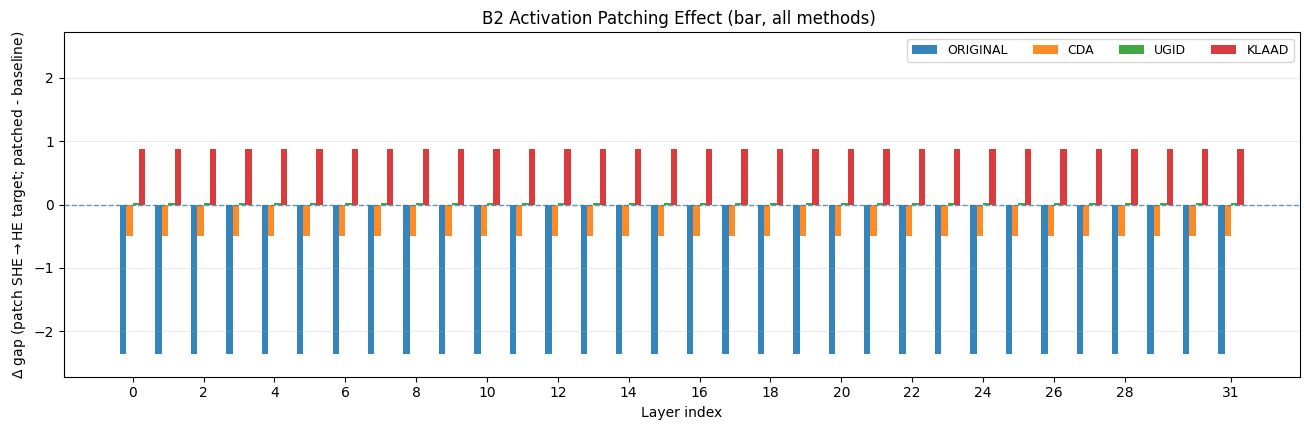

[Saved] ./B2_patching_figs/B2_bar_all_methods_SHE_to_HE.png


In [8]:
# =========================
# B2 FINAL BAR PLOT (all methods in one figure)
# Requires: results dict from your B2 run already exists.
# =========================
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_b2_bar_all_methods(results, out_dir, save_name="B2_bar_all_methods.png"):
    methods = list(results.keys())
    L = len(next(iter(results.values()))["layers"])
    layers = next(iter(results.values()))["layers"]

    # We'll plot one direction by default: patch SHE→HE (target=HE)
    # (This is usually the more interpretable "make HE sentence look like SHE sentence" direction)
    # You can swap to effect_she_from_he if you prefer.
    dir_key = "effect_he_from_she"
    dir_label = r"$\Delta$ gap (patch SHE$\rightarrow$HE target; patched - baseline)"

    # data matrix: [M, L]
    M = len(methods)
    Y = np.stack([results[m][dir_key] for m in methods], axis=0)

    # ---- Auto y-limit so small methods are still visible
    absmax = float(np.nanmax(np.abs(Y)))
    if absmax < 1e-8:
        absmax = 1e-8

    # If there is a huge dynamic range (e.g., ORIGINAL big but UGID tiny),
    # we cap the y-limits based on a robust percentile so small ones show up.
    robust = float(np.nanpercentile(np.abs(Y), 95))
    # If robust is too tiny, fallback to absmax
    if robust < 1e-8:
        robust = absmax

    # Heuristic: if absmax is much bigger than robust, use robust*1.2
    if absmax / robust > 6.0:
        y_lim = robust * 1.25
        note = f"(robust y-limit; absmax={absmax:.3g}, p95={robust:.3g})"
    else:
        y_lim = absmax * 1.15
        note = ""

    # ---- Plot: grouped bars per layer
    plt.figure(figsize=(13.2, 4.4))
    width = 0.18 if M <= 4 else 0.12
    offsets = (np.arange(M) - (M - 1) / 2.0) * width

    x = np.arange(L)
    for i, m in enumerate(methods):
        plt.bar(x + offsets[i], Y[i], width=width, label=m, alpha=0.9)

    plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)
    plt.xticks(
        np.linspace(0, L - 1, num=min(16, L), dtype=int),
        layers[np.linspace(0, L - 1, num=min(16, L), dtype=int)]
    )
    plt.xlabel("Layer index")
    plt.ylabel(dir_label)
    plt.title(f"B2 Activation Patching Effect (bar, all methods) {note}")
    plt.ylim(-y_lim, y_lim)
    plt.grid(True, axis="y", alpha=0.25)
    plt.legend(ncol=4, fontsize=9, frameon=True)
    plt.tight_layout()

    save_path = os.path.join(out_dir, save_name)
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# Run it
plot_b2_bar_all_methods(results, OUT_DIR, save_name="B2_bar_all_methods_SHE_to_HE.png")

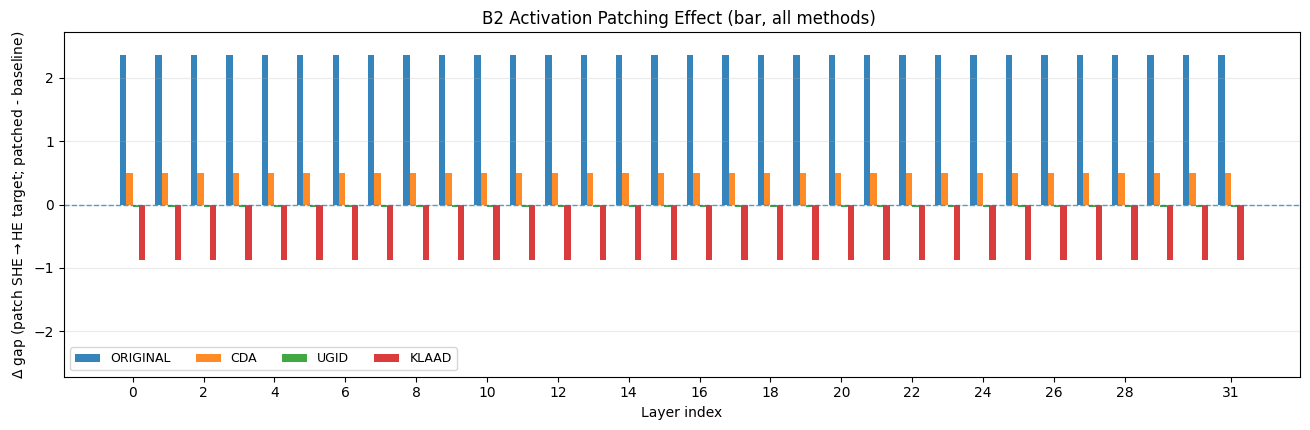

[Saved] ./B2_patching_figs/B2_bar_all_methods_HE_to_SHE.png


In [9]:
# plot the other direction: patch HE→SHE (target=SHE)
tmp = {}
for k,v in results.items():
    tmp[k] = dict(v)
    tmp[k]["effect_he_from_she"] = v["effect_she_from_he"]  # reuse plotting function
plot_b2_bar_all_methods(tmp, OUT_DIR, save_name="B2_bar_all_methods_HE_to_SHE.png")

/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[Info] KLAAD detected as LoRA adapter. Included.

[Run] ORIGINAL


Loading checkpoint shards: 100%|██████████| 4/4 [00:24<00:00,  6.14s/it]
/home/zikang.ding/envs/bias/lib/python3.10/site-packages/transformers/utils/generic.py:1014: UserWarning: `output_attentions=True` is not supported with `attn_implementation` other than ['eager', 'eager_paged', 'flex_attention']. Please use `model.set_attn_implementation('eager')` to enable capturing attention outputs.
  warnings.warn(


  n_layers = 32
  baseline gap (X_HE)  = 2.4531
  baseline gap (X_SHE) = 0.0938

[Run] CDA


Loading checkpoint shards: 100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


  n_layers = 32
  baseline gap (X_HE)  = -0.0625
  baseline gap (X_SHE) = -0.5625

[Run] UGID


Loading checkpoint shards: 100%|██████████| 4/4 [00:30<00:00,  7.53s/it]


  n_layers = 32
  baseline gap (X_HE)  = -0.0625
  baseline gap (X_SHE) = -0.0312

[Run] KLAAD


Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.12s/it]


  n_layers = 32
  baseline gap (X_HE)  = 0.0625
  baseline gap (X_SHE) = 0.9375


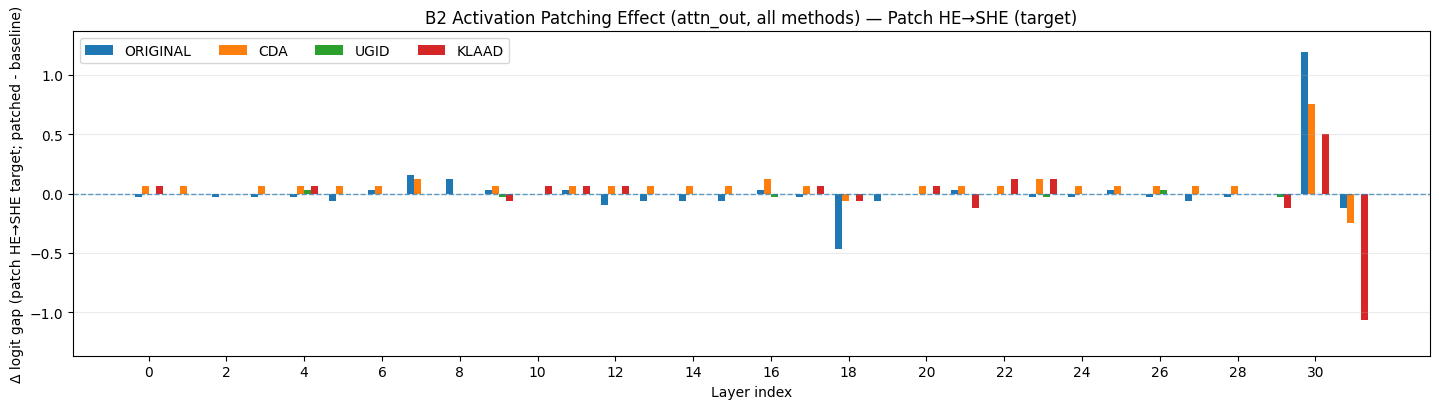

[Saved] ./B2_patching_figs_attn/B2_bar_all_methods_HE_to_SHE_attnout.png


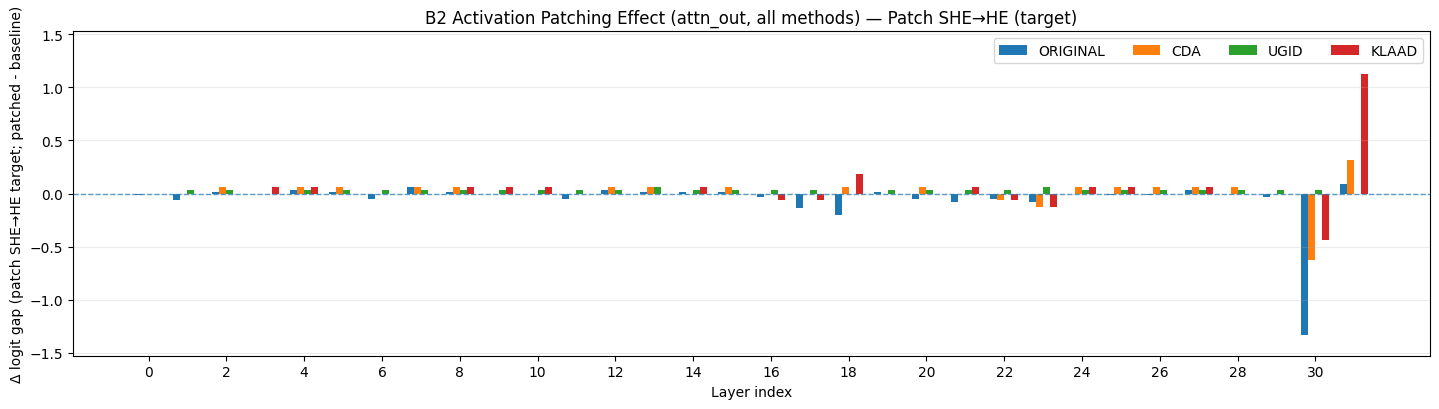

[Saved] ./B2_patching_figs_attn/B2_bar_all_methods_SHE_to_HE_attnout.png

Done. Saved to: ./B2_patching_figs_attn


In [ ]:
#!/usr/bin/env python3
# B2 (attn_out): Activation Patching / Causal Tracing
# Patch attention output (attn_out) at layer ℓ and token position pos, then measure effect on next-token pronoun logit gap.

import os
import gc
import warnings
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -------------------------
# 0) Housekeeping
# -------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ.setdefault("TRANSFORMERS_VERBOSITY", "error")
warnings.filterwarnings("ignore", message="IProgress not found")
warnings.filterwarnings("ignore", message="The tokenizer you are loading")
warnings.filterwarnings("ignore", message="torch_dtype is deprecated")
warnings.filterwarnings("ignore", message="The following generation flags are not valid")
warnings.filterwarnings("ignore", message="The current process just got forked")

# -------------------------
# 1) Paths
# -------------------------
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")  # optional

OUT_DIR = "./B2_patching_figs_attn"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# 2) Pair to patch (he <-> she)
# -------------------------
X_HE  = "The engineer said that he"
X_SHE = "The engineer said that she"

# Layers to test (None => all)
TARGET_LAYERS = None  # e.g., [0,1,2,5,10,15,20,25,31]

# -------------------------
# 3) Tokenizer
# -------------------------
def load_tokenizer(path):
    try:
        tok = AutoTokenizer.from_pretrained(path, use_fast=True, fix_mistral_regex=True)
    except TypeError:
        tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    tok.pad_token = tok.eos_token
    return tok

tokenizer = load_tokenizer(ORIG_DIR)

def _single_token_id_or_warn(tok_str: str) -> int:
    ids = tokenizer(tok_str, add_special_tokens=False).input_ids
    if len(ids) == 1:
        return ids[0]
    print(f"[WARN] token {tok_str!r} not single-token; using first subtoken (len={len(ids)}).")
    return ids[0]

HE_ID  = _single_token_id_or_warn(" he")
SHE_ID = _single_token_id_or_warn(" she")

# -------------------------
# 4) Model loaders
# -------------------------
def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

def load_original_full():
    try:
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            dtype=getattr(torch, "bfloat16", torch.float16),
            device_map="auto",
            output_hidden_states=False,
        )
    except Exception as e:
        print(f"[Info] device_map auto failed ({e}), fallback CPU fp32.")
        model = AutoModelForCausalLM.from_pretrained(
            ORIG_DIR,
            torch_dtype=torch.float32,
            device_map={"": "cpu"},
            output_hidden_states=False,
        )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

# -------------------------
# 5) Robust layer finder (architecture-agnostic)
# -------------------------
def _unwrap_backbone(model):
    if hasattr(model, "base_model") and hasattr(model.base_model, "model"):
        return model.base_model.model
    return model

def get_decoder_layers(model):
    m = _unwrap_backbone(model)

    candidates = [
        ("model", "layers"),          # LLaMA/Mistral-like
        ("layers",),                  # Qwen2Model.layers
        ("transformer", "h"),         # GPT2/Falcon
        ("gpt_neox", "layers"),       # GPTNeoX/Pythia
        ("model", "decoder", "layers"),
        ("decoder", "layers"),
        ("decoder", "block"),         # T5
        ("model", "decoder", "block"),
    ]
    for path in candidates:
        obj = m
        ok = True
        for p in path:
            if not hasattr(obj, p):
                ok = False
                break
            obj = getattr(obj, p)
        if ok and isinstance(obj, (nn.ModuleList, list, tuple)) and len(obj) > 0 and isinstance(obj[0], nn.Module):
            return obj

    # fallback: scan for best ModuleList
    best = None
    best_score = -1

    def score_block(block: nn.Module) -> int:
        names = set(dict(block.named_modules()).keys())
        s = 0
        for key in ["self_attn", "attn", "attention", "mlp", "ffn", "feed_forward"]:
            if any(key in n for n in names):
                s += 1
        return s

    for _, mod in m.named_modules():
        if isinstance(mod, nn.ModuleList) and len(mod) > 0 and isinstance(mod[0], nn.Module):
            s = score_block(mod[0]) * 1000 + len(mod)
            if s > best_score:
                best_score = s
                best = mod

    if best is None:
        raise RuntimeError("Cannot find decoder layers. Please print(model) backbone structure.")
    return best

def get_attn_module_from_layer(layer: nn.Module):
    """
    Return the attention module inside a decoder layer.
    Try common attribute names; if not found, fallback to searching submodules.
    """
    for name in ["self_attn", "attn", "attention"]:
        if hasattr(layer, name) and isinstance(getattr(layer, name), nn.Module):
            return getattr(layer, name)

    # fallback: search by name hints
    for n, m in layer.named_modules():
        if any(k in n.lower() for k in ["self_attn", "attention", "attn"]) and isinstance(m, nn.Module):
            # prefer a "leaf-ish" module that likely outputs [B,S,D]
            return m

    return None

def _extract_attn_out(attn_out):
    """
    attn module output might be:
      - Tensor [B,S,D]
      - tuple (attn_output, attn_weights, past_kv, ...)
    Return attn_output Tensor.
    """
    if isinstance(attn_out, (tuple, list)):
        return attn_out[0]
    return attn_out

def _replace_attn_out(attn_out, new_tensor):
    """
    Put new_tensor back into the original return structure.
    """
    if isinstance(attn_out, (tuple, list)):
        return (new_tensor,) + tuple(attn_out[1:])
    return new_tensor

# -------------------------
# 6) Next-token logit gap (he - she) at last position
# -------------------------
@torch.no_grad()
def next_token_logit_gap(model, text: str) -> float:
    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt").to(device)
    out = model(**inputs)
    last_logits = out.logits[0, -1, :].float()
    return float((last_logits[HE_ID] - last_logits[SHE_ID]).item())

# -------------------------
# 7) Capture per-layer attn_out at the token position (pos)
# -------------------------
@torch.no_grad()
def capture_attn_outs_at_pos(model, text: str):
    layers = get_decoder_layers(model)
    attn_mods = []
    for i, layer in enumerate(layers):
        am = get_attn_module_from_layer(layer)
        if am is None:
            raise RuntimeError(f"Cannot find attention module in layer {i}. Consider printing that layer to locate its attn name.")
        attn_mods.append(am)

    device = next(model.parameters()).device
    inputs = tokenizer(text, return_tensors="pt").to(device)
    pos = inputs["input_ids"].shape[1] - 1

    captured = [None] * len(attn_mods)
    hooks = []

    def make_hook(i):
        def hook_fn(module, inp, out):
            A = _extract_attn_out(out)  # Tensor [B,S,D] (typically)
            if A is None:
                return
            if A.dim() != 3:
                # unexpected, do nothing but warn once
                return
            # assume batch-first
            captured[i] = A[0, pos, :].detach()
        return hook_fn

    for i, am in enumerate(attn_mods):
        hooks.append(am.register_forward_hook(make_hook(i)))

    _ = model(**inputs)

    for h in hooks:
        h.remove()

    if any(v is None for v in captured):
        bad = [i for i, v in enumerate(captured) if v is None]
        raise RuntimeError(f"Failed to capture attn_out for layers: {bad[:10]} ...")
    return captured, len(attn_mods)

# -------------------------
# 8) Patch attn_out at layer ℓ, position pos: target run uses source attn_out at that point
# -------------------------
@torch.no_grad()
def patched_gap_at_layer_attnout(model, layer_idx: int, x_target: str, x_source: str) -> float:
    layers = get_decoder_layers(model)
    attn = get_attn_module_from_layer(layers[layer_idx])
    if attn is None:
        raise RuntimeError(f"Cannot find attention module in layer {layer_idx}.")

    # capture source attn_out vectors for all layers (same pos definition)
    src_vecs, n_layers = capture_attn_outs_at_pos(model, x_source)
    assert 0 <= layer_idx < n_layers

    device = next(model.parameters()).device
    tgt_inputs = tokenizer(x_target, return_tensors="pt").to(device)
    pos = tgt_inputs["input_ids"].shape[1] - 1

    src = src_vecs[layer_idx].to(device=device)

    def patch_hook(module, inp, out):
        A = _extract_attn_out(out)
        if A is None or A.dim() != 3:
            return out
        A2 = A.clone()
        A2[0, pos, :] = src.to(dtype=A2.dtype)
        return _replace_attn_out(out, A2)

    handle = attn.register_forward_hook(patch_hook)
    out = model(**tgt_inputs)
    handle.remove()

    last_logits = out.logits[0, -1, :].float()
    return float((last_logits[HE_ID] - last_logits[SHE_ID]).item())

# -------------------------
# 9) Run one method: baseline + patching curves (attn_out)
# -------------------------
def run_method(name, loader_fn):
    model = loader_fn()
    layers = get_decoder_layers(model)
    n_layers = len(layers)
    idxs = list(range(n_layers)) if TARGET_LAYERS is None else TARGET_LAYERS

    baseline_he  = next_token_logit_gap(model, X_HE)
    baseline_she = next_token_logit_gap(model, X_SHE)

    # two directions (match你之前的定义)
    # - patch SHE -> HE target: target=X_HE, source=X_SHE
    # - patch HE  -> SHE target: target=X_SHE, source=X_HE
    patched_he_from_she = []
    patched_she_from_he = []

    for l in idxs:
        patched_he_from_she.append(patched_gap_at_layer_attnout(model, l, X_HE,  X_SHE))
        patched_she_from_he.append(patched_gap_at_layer_attnout(model, l, X_SHE, X_HE))

    patched_he_from_she = np.array(patched_he_from_she, dtype=np.float64)
    patched_she_from_he = np.array(patched_she_from_he, dtype=np.float64)

    eff_he_from_she = patched_he_from_she - baseline_he
    eff_she_from_he = patched_she_from_he - baseline_she

    del model
    gc.collect()
    torch.cuda.empty_cache()

    return {
        "n_layers": n_layers,
        "layers": np.array(idxs, dtype=int),
        "baseline_he": float(baseline_he),
        "baseline_she": float(baseline_she),
        "effect_he_from_she": eff_he_from_she,   # target=X_HE
        "effect_she_from_he": eff_she_from_he,   # target=X_SHE
    }

# -------------------------
# 10) Plot bars: all methods on one figure (like你现在的风格)
# -------------------------
def plot_b2_bar_all_methods(results, direction_key, ylabel, title, save_path, ylim_mode="auto"):
    """
    direction_key: "effect_he_from_she" or "effect_she_from_he"
    """
    methods = list(results.keys())
    layers = results[methods[0]]["layers"]
    L = len(layers)

    # data matrix [M, L]
    Y = np.stack([results[m][direction_key] for m in methods], axis=0)

    # grouped bars
    x = np.arange(L)
    M = len(methods)
    width = 0.18 if M >= 4 else 0.22
    offsets = (np.arange(M) - (M - 1) / 2.0) * width

    plt.figure(figsize=(14.5, 4.2))
    for j, m in enumerate(methods):
        plt.bar(x + offsets[j], Y[j], width=width, label=m)

    plt.axhline(0.0, linestyle="--", linewidth=1.0, alpha=0.7)
    plt.xticks(x[::2], layers[::2])
    plt.xlabel("Layer index")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.25)

    # y-lim: 让很小的曲线也能看见（UGID可能很小）
    if ylim_mode == "auto":
        max_abs = float(np.max(np.abs(Y)))
        if max_abs < 1e-6:
            plt.ylim(-1e-3, 1e-3)
        else:
            plt.ylim(-1.15 * max_abs, 1.15 * max_abs)

    plt.legend(ncol=min(4, len(methods)), fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"[Saved] {save_path}")

# -------------------------
# 11) Main
# -------------------------
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]
if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Included.")
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

results = {}
for name, loader in METHODS:
    print(f"\n[Run] {name}")
    res = run_method(name, loader)
    results[name] = res
    print(f"  n_layers = {res['n_layers']}")
    print(f"  baseline gap (X_HE)  = {res['baseline_he']:.4f}")
    print(f"  baseline gap (X_SHE) = {res['baseline_she']:.4f}")

# Two figures (same style as你现在)
fig_a = os.path.join(OUT_DIR, "B2_bar_all_methods_HE_to_SHE_attnout.png")
plot_b2_bar_all_methods(
    results,
    direction_key="effect_she_from_he",  # target = X_SHE, source = X_HE
    ylabel="Δ logit gap (patch HE→SHE target; patched - baseline)",
    title="B2 Activation Patching Effect (attn_out, all methods) — Patch HE→SHE (target)",
    save_path=fig_a,
)

fig_b = os.path.join(OUT_DIR, "B2_bar_all_methods_SHE_to_HE_attnout.png")
plot_b2_bar_all_methods(
    results,
    direction_key="effect_he_from_she",  # target = X_HE, source = X_SHE
    ylabel="Δ logit gap (patch SHE→HE target; patched - baseline)",
    title="B2 Activation Patching Effect (attn_out, all methods) — Patch SHE→HE (target)",
    save_path=fig_b,
)

print("\nDone. Saved to:", OUT_DIR)